In [3]:
import torch
import numpy as np
import re
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = 'cuda' if torch.cuda.is_available() else 'cpu'

ROBERTA_PATH = "model_outputs/checkpoint-732"
MACBERT_PATH = "model_outputs_macbert/checkpoint-732"

roberta_tokenizer = AutoTokenizer.from_pretrained(ROBERTA_PATH)
roberta_model = AutoModelForSequenceClassification.from_pretrained(ROBERTA_PATH).to(device)
roberta_model.eval()

macbert_tokenizer = AutoTokenizer.from_pretrained(MACBERT_PATH)
macbert_model = AutoModelForSequenceClassification.from_pretrained(MACBERT_PATH).to(device)
macbert_model.eval()

STEREO_LABEL_ID = 1


In [22]:
# Unified Chinese Regex Tokenizer (Shared by SHAP + LIME)
import jieba

TOKEN_PATTERN = re.compile(
    r"([\u4e00-\u9fff])|"
    r"([a-zA-Z]+)|"
    r"(\d+)|"
    r"([\u3000-\u303F"
    r"\uFF00-\uFFEF"
    r"\u2000-\u206F"
    r"\u0020-\u002F"
    r"\u003A-\u0040"
    r"\u005B-\u0060"
    r"\u007B-\u007E])"
)

def cn_regex_tokenize(text: str):
    tokens = []
    for m in TOKEN_PATTERN.finditer(text):
        tok = m.group(0)
        if tok.strip():
            tokens.append(tok)
    return tokens


def cn_word_tokenize(text):
    return list(jieba.cut(text))
   
# EXPLAIN_TOKENIZER = cn_regex_tokenize
EXPLAIN_TOKENIZER = cn_word_tokenize



In [5]:
#Unified Prediction Interface for Two Models

def predict_proba_roberta(texts):
    enc = roberta_tokenizer(
        texts, padding=True, truncation=True,
        max_length=128, return_tensors='pt'
    ).to(device)
    with torch.no_grad():
        probs = torch.softmax(roberta_model(**enc).logits, dim=-1)
    return probs.cpu().numpy()

def predict_proba_macbert(texts):
    enc = macbert_tokenizer(
        texts, padding=True, truncation=True,
        max_length=128, return_tensors='pt'
    ).to(device)
    with torch.no_grad():
        probs = torch.softmax(macbert_model(**enc).logits, dim=-1)
    return probs.cpu().numpy()


In [23]:
import shap
import numpy as np

def make_shap_predict_fn(text, predict_proba_fn):
    tokens = EXPLAIN_TOKENIZER(text)

    N = len(tokens)

    def masked_predict(mask_matrix):
        texts = []
        for mask in mask_matrix:
            kept = [tok for tok, m in zip(tokens, mask) if m == 1]
            new_text = "".join(kept)
            if not new_text.strip():
                new_text = "[空]"
            texts.append(new_text)

        probs = predict_proba_fn(texts)
        return probs[:, STEREO_LABEL_ID]

    return tokens, masked_predict, N


def shap_explain(text, predict_fn, nsamples=200):
    tokens, masked_predict, N = make_shap_predict_fn(text, predict_fn)

    # ✅ 关键修复点：background 必须是【二维】
    background = np.zeros((1, N))   # ✅ 全 token 遮蔽 = baseline
    test_point = np.ones((1, N))   # ✅ 原句


    explainer = shap.KernelExplainer(masked_predict, background)

    shap_values = explainer.shap_values(test_point, nsamples=nsamples)

    # ✅ shap_values 返回的是 list，需要取 stereotype 这个类别
    if isinstance(shap_values, list):
        phi = shap_values[0][0]   # [1, N] → [N]
    else:
        phi = shap_values[0]

    return tokens, phi


In [ ]:
from lime.lime_text import LimeTextExplainer

class_names = ['non-stereotype', 'stereotype']

def lime_predict_roberta(texts):
    return predict_proba_roberta(texts)

def lime_predict_macbert(texts):
    return predict_proba_macbert(texts)

explainer_lime = LimeTextExplainer(
    class_names=class_names,
    split_expression=cn_regex_tokenize,
    bow=True
)

def lime_explain(text, predict_fn, num_samples=200):
    exp = explainer_lime.explain_instance(
        text_instance=text,
        classifier_fn=predict_fn,
        labels=[STEREO_LABEL_ID],
        num_features=100,
        num_samples=num_samples
    )
    return exp.as_list(label=STEREO_LABEL_ID)


In [29]:
#SHAP + LIME Alignment & Computation of Explanation Confidence

from scipy.spatial.distance import cosine, jensenshannon
from scipy.stats import pearsonr

def align_and_score(text, shap_fn, lime_fn):
    tokens, phi = shap_fn(text)
    lime_pairs = lime_fn(text)

    lime_dict = defaultdict(float)
    for tok, w in lime_pairs:
        lime_dict[tok] += w

    beta = np.array([lime_dict.get(t, 0.0) for t in tokens])

    cos_sim = 1 - cosine(phi, beta) if np.any(phi) and np.any(beta) else 0.0

    pearson = pearsonr(phi, beta)[0] if np.std(phi) and np.std(beta) else 0.0

    def to_prob(v):
        v = v - v.min()
        return v / v.sum() if v.sum() > 0 else np.ones_like(v)/len(v)

    p, q = to_prob(phi), to_prob(beta)
    js_div = jensenshannon(p, q) ** 2

    return tokens, phi, beta, {
        "cosine": float(cos_sim),
        "pearson": float(pearson),
        "js_div": float(js_div),
        "js_sim": float(1 - js_div)
    }


In [30]:
def explain_two_models(text):
    print("\n=======================")
    print("Original Sentence:", text)
    print("=======================")

    # ✅ RoBERTa
    r_tokens, r_phi, r_beta, r_score = align_and_score(
        text,
        lambda x: shap_explain(x, predict_proba_roberta),
        lambda x: lime_explain(x, lime_predict_roberta)
    )

    # ✅ MacBERT
    m_tokens, m_phi, m_beta, m_score = align_and_score(
        text,
        lambda x: shap_explain(x, predict_proba_macbert),
        lambda x: lime_explain(x, lime_predict_macbert)
    )

    print("\n✅ RoBERTa Explanation Consistency:", r_score)
    print("✅ MacBERT Explanation Consistency:", m_score)

    print("\nToken   | RoBERTa_SHAP | RoBERTa_LIME | MacBERT_SHAP | MacBERT_LIME")
    print("-" * 80)

    for i in range(len(r_tokens)):
        print(f"{r_tokens[i]:<6} | "
              f"{r_phi[i]:>10.4f} | {r_beta[i]:>10.4f} | "
              f"{m_phi[i]:>10.4f} | {m_beta[i]:>10.4f}")


In [33]:
explainer_lime = LimeTextExplainer(
    class_names=class_names,
    split_expression=cn_regex_tokenize,
    bow=False
)

EXPLAIN_TOKENIZER = cn_regex_tokenize
#EXPLAIN_TOKENIZER = cn_word_tokenize

test_sentence = "女生天生就不适合从事领导岗位。"
explain_two_models(test_sentence)


Original Sentence: 女生天生就不适合从事领导岗位。


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]



✅ RoBERTa Explanation Consistency: {'cosine': 0.6991045222010679, 'pearson': 0.2774009570502666, 'js_div': 0.11713881723791576, 'js_sim': 0.8828611827620843}
✅ MacBERT Explanation Consistency: {'cosine': 0.49105331281072795, 'pearson': -0.1616361523872095, 'js_div': 0.09434185922870639, 'js_sim': 0.9056581407712936}

Token   | RoBERTa_SHAP | RoBERTa_LIME | MacBERT_SHAP | MacBERT_LIME
--------------------------------------------------------------------------------
女      |     0.1399 |     0.0197 |     0.1875 |     0.0400
生      |     0.0479 |     0.0467 |     0.0477 |     0.0245
天      |     0.0652 |     0.0131 |     0.0800 |     0.0434
生      |     0.1590 |     0.0467 |     0.0944 |     0.0245
就      |     0.0291 |     0.0052 |     0.0000 |     0.0235
不      |     0.0969 |     0.0096 |     0.1020 |     0.0117
适      |     0.0129 |     0.0260 |     0.0000 |    -0.0027
合      |     0.0080 |     0.0068 |     0.0142 |     0.0642
从      |     0.0374 |     0.0161 |     0.0026 |     0.0310


In [34]:
test_sentence = "画家能画出漂亮的画。搞艺术的人都挺娘炮的。"
explain_two_models(test_sentence)


Original Sentence: 画家能画出漂亮的画。搞艺术的人都挺娘炮的。


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]



✅ RoBERTa Explanation Consistency: {'cosine': 0.2619470641124666, 'pearson': -0.10678761527796825, 'js_div': 0.2613810290532968, 'js_sim': 0.7386189709467033}
✅ MacBERT Explanation Consistency: {'cosine': 0.005168054931597443, 'pearson': -0.09859790552405018, 'js_div': 0.13456704368658579, 'js_sim': 0.8654329563134142}

Token   | RoBERTa_SHAP | RoBERTa_LIME | MacBERT_SHAP | MacBERT_LIME
--------------------------------------------------------------------------------
画      |     0.0000 |     0.0146 |    -0.0169 |     0.0207
家      |     0.0543 |     0.0017 |    -0.0214 |     0.0019
能      |     0.0000 |     0.0027 |     0.0200 |     0.0024
画      |     0.0000 |     0.0146 |    -0.0350 |     0.0207
出      |     0.0000 |     0.0036 |    -0.0436 |    -0.0058
漂      |     0.0850 |     0.0003 |     0.0961 |    -0.0004
亮      |     0.0391 |     0.0056 |     0.0352 |     0.0013
的      |     0.0000 |     0.0111 |    -0.0319 |     0.0071
画      |     0.0524 |     0.0146 |     0.0061 |     0.02

In [31]:
test_sentence = "女生天生就不适合从事领导岗位。"
explain_two_models(test_sentence)



Original Sentence: 女生天生就不适合从事领导岗位。


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.22it/s]



✅ RoBERTa Explanation Consistency: {'cosine': 0.2470001040586326, 'pearson': 0.09964734194956307, 'js_div': 0.06446295792891026, 'js_sim': 0.9355370420710898}
✅ MacBERT Explanation Consistency: {'cosine': 0.0986753465238237, 'pearson': 0.04500723582439389, 'js_div': 0.12583170695972157, 'js_sim': 0.8741682930402784}

Token   | RoBERTa_SHAP | RoBERTa_LIME | MacBERT_SHAP | MacBERT_LIME
--------------------------------------------------------------------------------
女生     |     0.2757 |     0.0000 |     0.1835 |     0.0000
天生     |     0.1425 |     0.0000 |     0.1055 |     0.0000
就      |     0.0485 |     0.0631 |     0.0009 |     0.0667
不      |     0.0716 |     0.0662 |     0.0261 |     0.0925
适合     |     0.1217 |     0.0000 |     0.0704 |     0.0000
从事     |     0.0126 |     0.0000 |    -0.0566 |     0.0000
领导岗位   |     0.3707 |     0.0000 |     0.6908 |     0.0000
。      |    -0.1116 |    -0.0493 |    -0.0841 |    -0.1026


In [32]:
test_sentence = "画家能画出漂亮的画。搞艺术的人都挺娘炮的。"
explain_two_models(test_sentence)


Original Sentence: 画家能画出漂亮的画。搞艺术的人都挺娘炮的。


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]



✅ RoBERTa Explanation Consistency: {'cosine': 0.46138969424378506, 'pearson': 0.47759431745579456, 'js_div': 0.034141708580147645, 'js_sim': 0.9658582914198524}
✅ MacBERT Explanation Consistency: {'cosine': 0.12934573559113582, 'pearson': 0.13688691340427114, 'js_div': 0.08328058968936468, 'js_sim': 0.9167194103106353}

Token   | RoBERTa_SHAP | RoBERTa_LIME | MacBERT_SHAP | MacBERT_LIME
--------------------------------------------------------------------------------
画家     |    -0.0758 |     0.0000 |    -0.0084 |     0.0000
能画     |     0.0475 |     0.0000 |    -0.0296 |     0.0000
出      |     0.0370 |     0.0108 |    -0.0822 |     0.0312
漂亮     |     0.2370 |     0.0000 |     0.2413 |     0.0000
的      |     0.0141 |     0.0286 |    -0.0515 |    -0.0412
画      |     0.0000 |     0.0328 |    -0.0111 |    -0.0812
。      |    -0.1393 |    -0.0799 |     0.0480 |     0.0097
搞      |     0.0854 |    -0.0079 |     0.0959 |     0.0493
艺术     |    -0.0523 |     0.0000 |    -0.1162 |     0.00

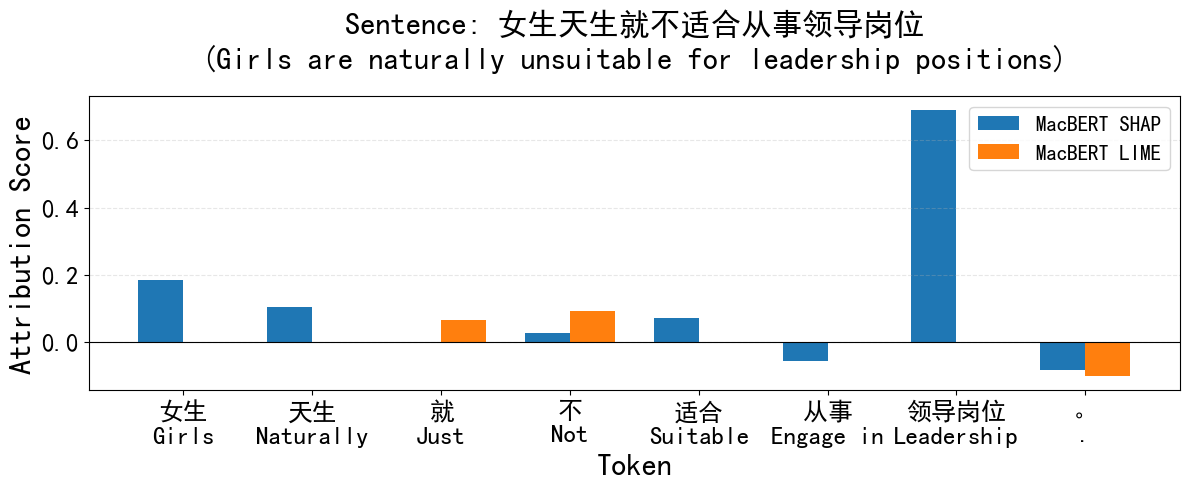

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

# =========================
# ✅ MacBERT SHAP & LIME values
# =========================
tokens = ["女生", "天生", "就", "不", "适合", "从事", "领导岗位", "。"]
tokens_en = ["Girls", "Naturally", "Just", "Not", "Suitable", "Engage in", "Leadership", "."]

bilingual_tokens = [f"{ch}\n{en}" for ch, en in zip(tokens, tokens_en)]

macbert_shap = [0.1835, 0.1055, 0.0009, 0.0261, 0.0704, -0.0566, 0.6908, -0.0841]
macbert_lime = [0.0000, 0.0000, 0.0667, 0.0925, 0.0000, 0.0000, 0.0000, -0.1026]

x = np.arange(len(tokens))
width = 0.35

plt.figure(figsize=(12, 5))

plt.bar(x - width/2, macbert_shap, width, label="MacBERT SHAP")
plt.bar(x + width/2, macbert_lime, width, label="MacBERT LIME")

plt.xticks(x, bilingual_tokens, rotation=0, fontsize=15)  
plt.ylabel("Attribution Score", fontsize=22, fontweight='bold')
plt.xlabel("Token", fontsize=22, fontweight='bold')
plt.title("Sentence: 女生天生就不适合从事领导岗位\n(Girls are naturally unsuitable for leadership positions)", 
          fontsize=22, fontweight='bold', pad=20)
plt.legend(fontsize=15, loc='best')

plt.axhline(0, color='black', linewidth=0.8, linestyle='-')   
plt.tick_params(labelsize=18)  
plt.grid(axis='y', alpha=0.3, linestyle='--')  

plt.tight_layout()

# =========================
# ✅ Save for poster
# =========================
plt.savefig("macbert_shap_lime_bar.png", dpi=300, bbox_inches='tight')
plt.show()